In [1]:
!pip install transformers --quiet
import json
import math
import random
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from transformers import GPT2Tokenizer, GPT2Model, GPT2Config, get_linear_schedule_with_warmup, pipeline

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 43.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 29.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 9.9 MB/s eta 0:00:00


In [2]:
import os
from google.colab import drive

drive.mount('/content/gdrive')
myDrive_path = '/content/gdrive/My Drive/'
dir_path = os.path.join(myDrive_path, 'Intent_Analysis_Final_Project', 'intent-analysis-gpt2')

Mounted at /content/gdrive


In [7]:
import random 
data_name = "en-US.jsonl"

data_path = os.path.join(dir_path, data_name)
data = []
with open(data_path, 'r') as f:
    for line in f:
        data.append(json.loads(line))

In [8]:
from collections import defaultdict
intent_stats = defaultdict(int)
scenario_stats = defaultdict(int)
for entry in data:
    intent = entry['intent']
    scenario = entry['scenario']
    intent_stats[intent] +=1
    scenario_stats[scenario] +=1

In [9]:
unique_intents = sorted(list(set([entry['intent'] for entry in data])))
unique_scenarios = sorted(list(set([entry['scenario'] for entry in data])))
# random.seed(42)
# random.shuffle(unique_intents)
print(unique_intents)
print(unique_scenarios)
print(f"Number of unique intents: {len(unique_intents)}")

['alarm_query', 'alarm_remove', 'alarm_set', 'audio_volume_down', 'audio_volume_mute', 'audio_volume_other', 'audio_volume_up', 'calendar_query', 'calendar_remove', 'calendar_set', 'cooking_query', 'cooking_recipe', 'datetime_convert', 'datetime_query', 'email_addcontact', 'email_query', 'email_querycontact', 'email_sendemail', 'general_greet', 'general_joke', 'general_quirky', 'iot_cleaning', 'iot_coffee', 'iot_hue_lightchange', 'iot_hue_lightdim', 'iot_hue_lightoff', 'iot_hue_lighton', 'iot_hue_lightup', 'iot_wemo_off', 'iot_wemo_on', 'lists_createoradd', 'lists_query', 'lists_remove', 'music_dislikeness', 'music_likeness', 'music_query', 'music_settings', 'news_query', 'play_audiobook', 'play_game', 'play_music', 'play_podcasts', 'play_radio', 'qa_currency', 'qa_definition', 'qa_factoid', 'qa_maths', 'qa_stock', 'recommendation_events', 'recommendation_locations', 'recommendation_movies', 'social_post', 'social_query', 'takeaway_order', 'takeaway_query', 'transport_query', 'transpor

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
intent_weight = []
scenario_weight = []
for intent in unique_intents:
    intent_weight.append(1 - intent_stats[intent]/len(data))
for scenario in unique_scenarios:
    scenario_weight.append(1 - scenario_stats[scenario]/len(data))
intent_weight = torch.tensor(intent_weight, device=device)
scenario_weight = torch.tensor(scenario_weight, device=device)

In [15]:
class IntentDataset(Dataset):
    def __init__(self, data, unique_intents, unique_scenarios, tokenizer, partition='dev'):
        self.data = data
        self.current_dataset = [entry for entry in self.data if entry['partition'] == partition]
        self.intents = [entry["intent"] for entry in self.current_dataset]
        self.scenarios = [entry["scenario"] for entry in self.current_dataset]
        self.unique_intents = unique_intents
        self.unique_scenarios = unique_scenarios
        self.tokenizer = tokenizer
        self.intent_to_id = {intent: i for i, intent in enumerate(self.unique_intents)}
        self.id_to_intent = {i: intent for intent, i in self.intent_to_id.items()}
        self.scenario_to_id = {scenario: i for i, scenario in enumerate(self.unique_scenarios)}
        self.id_to_scenario = {i: scenario for scenario, i in self.scenario_to_id.items()}
        self.intent_labels = [self.intent_to_id[intent] for intent in self.intents]
        self.scenario_labels =[self.scenario_to_id[scenario] for scenario in self.scenarios] 
        self.input_data = [entry['utt'] for entry in self.current_dataset]
        self.encodings = self.tokenizer(self.input_data, return_tensors='pt', padding="max_length",max_length=40, truncation=True)

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['scenario_label'] = torch.tensor(self.scenario_labels[idx])
        item['intent_label'] = torch.tensor(self.intent_labels[idx])
        return item

    def __len__(self):
        return len(self.input_data)

In [10]:
class GPT2ForSequenceClassification(nn.Module):
    def __init__(self, config, intent_num, scenario_num):
        super().__init__()
        self.gpt2 = GPT2Model(config)
        self.dropout = nn.Dropout(0.2)
        self.intent_fc1 = nn.Linear(40960, intent_num)
        self.scenario_fc1 = nn.Linear(40960, scenario_num)

        
        self.intent_num = intent_num
        self.scenario_num = scenario_num
        
    def forward(self, input_ids, attention_mask=None, past_key_values=None):
        outputs = self.gpt2(input_ids, attention_mask=attention_mask)

        pooled_output = self.dropout(outputs[0])

        # Intent classification
        intent_logits = self.intent_fc1(pooled_output.flatten(start_dim=1))

        # Scenario classification
        scenario_logits = self.scenario_fc1(pooled_output.flatten(start_dim=1))

        return intent_logits, scenario_logits 

In [16]:
batch_size = 16
model_engine = "gpt2-medium"

tokenizer = GPT2Tokenizer.from_pretrained(model_engine)
tokenizer.add_special_tokens({'pad_token': '[PAD]'})

trainset = IntentDataset(data, unique_intents, unique_scenarios, tokenizer, partition='train')
valset = IntentDataset(data, unique_intents,unique_scenarios, tokenizer)
trainLoader = DataLoader(trainset, batch_size, shuffle=True, num_workers=2)
valLoader = DataLoader(valset, batch_size, shuffle=False, num_workers=2)

In [ ]:
s = tokenizer('I love my dog')['input_ids']
print(s)
[tokenizer.decode(x) for x in s]

[40, 1842, 616, 3290]


['I', ' love', ' my', ' dog']

In [17]:
config = GPT2Config.from_pretrained(model_engine)
model = GPT2ForSequenceClassification(config, len(unique_intents), len(unique_scenarios))
model.gpt2.resize_token_embeddings(len(tokenizer))

model_name = "gpt2-scenario-intent-analysis"
model_path = os.path.join(dir_path, model_name)
if os.path.exists(model_path):
    model.load_state_dict(torch.load(model_path))
    print(f"Loaded model: {model_name}")

model = model.to(device)

Loaded model: gpt2-scenario-intent-analysis


In [ ]:
epochs = 10

# Optimizer
optimal_lr = 2e-5
optimizer = torch.optim.AdamW(model.parameters(), lr=optimal_lr, weight_decay=0.01)

# Scheduler
total_steps = len(trainLoader) * epochs
warmup_ratio = 0.05
warmup_steps = int(warmup_ratio * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

In [ ]:
num_layers = 8
for param in model.gpt2.h[:num_layers].parameters():
    param.requires_grad = False
for param in model.gpt2.h[num_layers:].parameters():
    param.requires_grad = True

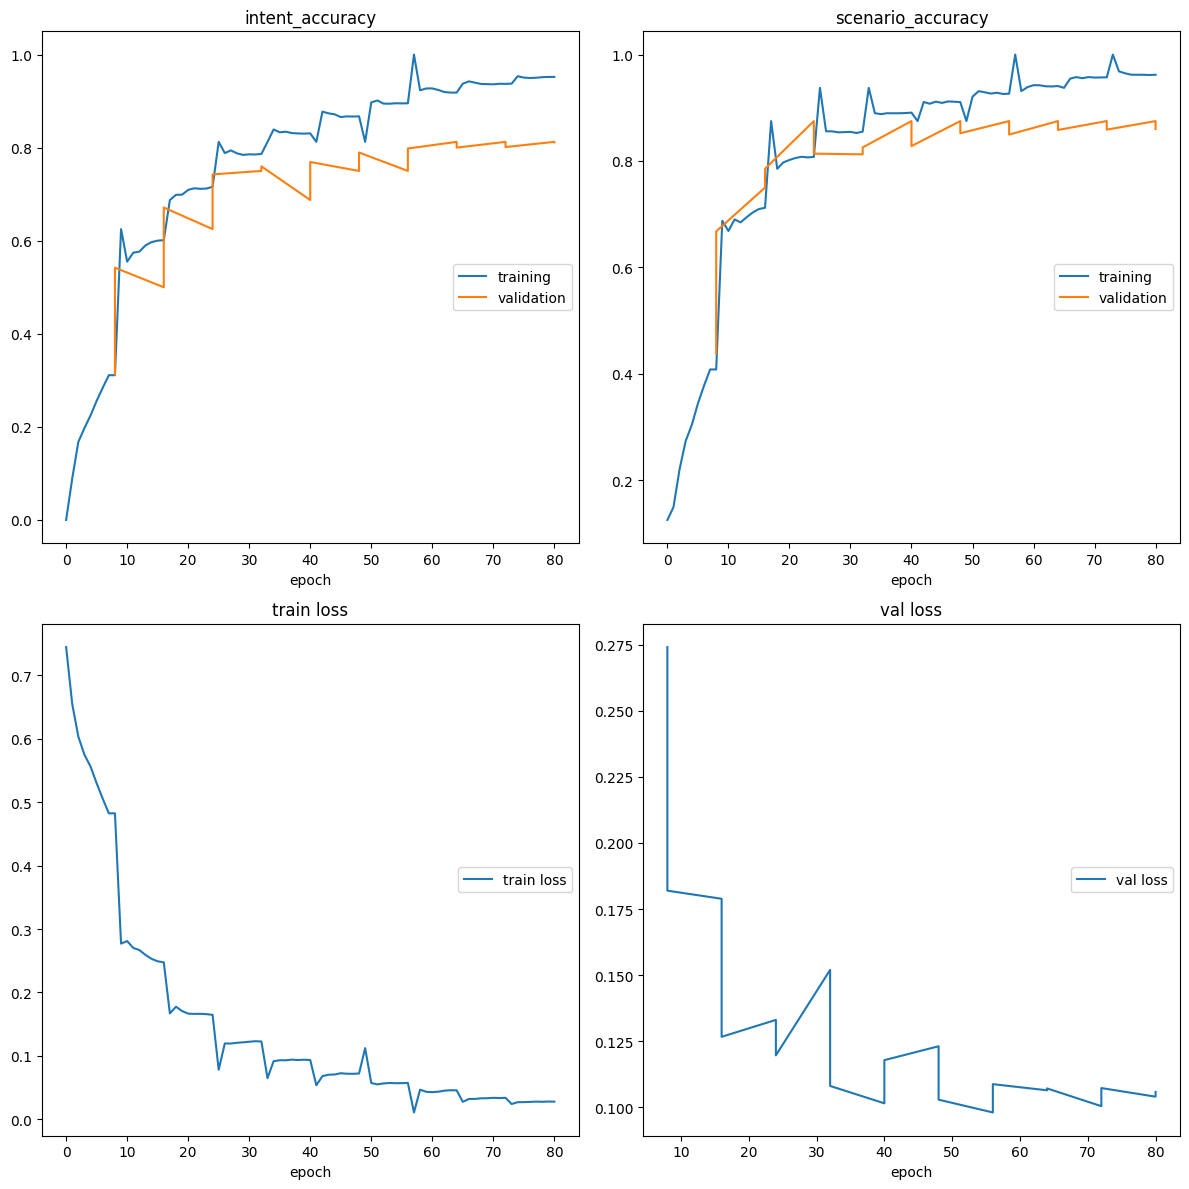

intent_accuracy
	training         	 (min:    0.000, max:    1.000, cur:    0.952)
	validation       	 (min:    0.312, max:    0.812, cur:    0.811)
scenario_accuracy
	training         	 (min:    0.125, max:    1.000, cur:    0.962)
	validation       	 (min:    0.438, max:    0.875, cur:    0.860)
train loss
	train loss       	 (min:    0.011, max:    0.745, cur:    0.028)
val loss
	val loss         	 (min:    0.098, max:    0.274, cur:    0.106)


In [ ]:
!pip install livelossplot --quiet
from livelossplot import PlotLosses

liveloss = PlotLosses()
current_step = 0
iters = 0
intent_ce = nn.CrossEntropyLoss(weight=intent_weight)
scenario_ce = nn.CrossEntropyLoss(weight=scenario_weight)
past_key_values = None

for epoch in range(epochs):
    logs = {}
    cumulative_loss = 0
    intent_cumulative_accuracy = 0
    scenario_cumulative_accuracy = 0
    num_samples = 0

    model.train()
    # print("In training loop...")
    for id, batch in enumerate(trainLoader):
        iters += 1
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        intent_labels = batch['intent_label'].to(device)
        scenario_labels = batch['scenario_label'].to(device)
        intent_logits, scenario_logits  = model(input_ids, attention_mask=attention_mask)
        model.zero_grad()
        intent_loss = intent_ce(intent_logits, intent_labels)
        scenario_loss = scenario_ce(scenario_logits, scenario_labels)
        losses = 2 * intent_loss + scenario_loss
        losses.backward()
        optimizer.step()
        scheduler.step()

        cumulative_loss += losses.item()
        intent_preds = torch.argmax(intent_logits, dim=1)
        scenario_preds = torch.argmax(scenario_logits, dim=1)
        intent_cumulative_accuracy += (intent_preds == intent_labels).sum().item()
        scenario_cumulative_accuracy += (scenario_preds == scenario_labels).sum().item()
        num_samples += input_ids.size(0)

        if id % 100 == 0:
            avg_train_loss = cumulative_loss / num_samples
            avg_train_intent_accuracy = intent_cumulative_accuracy / num_samples
            avg_train_scenario_accuracy = scenario_cumulative_accuracy / num_samples
            # print(f"Epoch {epoch}, Batch id: {id}, Accuracy: {avg_train_accuracy}, Loss: {avg_train_loss}")
            logs['train loss'] = avg_train_loss
            logs['intent_accuracy'] = avg_train_intent_accuracy
            logs['scenario_accuracy'] = avg_train_scenario_accuracy
            liveloss.update(logs)
            liveloss.send()
            current_step += 1
    
    model.eval()
    cumulative_loss = 0
    intent_cumulative_accuracy = 0
    scenario_cumulative_accuracy = 0
    num_samples = 0
    # print("In validation loop...")
    with torch.no_grad():
        for id, batch in enumerate(valLoader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            intent_labels = batch['intent_label'].to(device)
            scenario_labels = batch['scenario_label'].to(device)
            intent_logits, scenario_logits = model(input_ids, attention_mask=attention_mask)
            model.zero_grad()
            intent_loss = intent_ce(intent_logits, intent_labels)
            scenario_loss = scenario_ce(scenario_logits, scenario_labels)
            losses = intent_loss + scenario_loss
            cumulative_loss += losses.item()
            intent_preds = torch.argmax(intent_logits, dim=1)
            scenario_preds = torch.argmax(scenario_logits, dim=1)
            intent_cumulative_accuracy += (intent_preds == intent_labels).sum().item()
            scenario_cumulative_accuracy += (scenario_preds == scenario_labels).sum().item()
            num_samples += input_ids.size(0)

            if id % 100 == 0:
              avg_val_loss = cumulative_loss / num_samples
              avg_val_intent_accuracy = intent_cumulative_accuracy / num_samples
              avg_val_scenario_accuracy = scenario_cumulative_accuracy / num_samples
            # print(f"Epoch {epoch}, Batch id: {id}, Accuracy: {avg_train_accuracy}, Loss: {avg_train_loss}")
              logs['val loss'] = avg_val_loss
              logs['val_intent_accuracy'] = avg_val_intent_accuracy
              logs['val_scenario_accuracy'] = avg_val_scenario_accuracy
              liveloss.update(logs, current_step)
              liveloss.send()


In [ ]:
torch.save(model.state_dict(), model_path)

In [ ]:
def predict_intent(inputs, model=model):
    model.eval()
    input_ids = inputs['input_ids'].unsqueeze(0).to(device)
    attention_mask = inputs['attention_mask'].unsqueeze(0).to(device)
    with torch.no_grad(): 
        outputs, _ = model(input_ids, attention_mask=attention_mask)
    preds = torch.argmax(outputs, dim=1)
    return preds.item()

In [ ]:
testset = IntentDataset(data, unique_intents, unique_scenarios, tokenizer, partition='test')
testLoader = DataLoader(testset, batch_size, shuffle=False, num_workers=2)
index = 1
data_item = testset[index]

# Extract input_ids, attention_mask, and label from the data_item
input_ids = data_item['input_ids']
attention_mask = data_item['attention_mask']
intent_label = data_item['intent_label']

# Print the original text and label by decoding the input_ids
decoded_text = tokenizer.decode(input_ids, skip_special_tokens=True)
print(f"Text: {decoded_text}")
print(f"True label id: {intent_label.item()}")
print(f"True label: {testset.id_to_intent[intent_label.item()]}")

label_idx = predict_intent(data_item)
print(f"Pred label id: {label_idx}")
print(f"Pred label: {testset.id_to_intent[label_idx]}")


Text: quiet
True label id: 4
True label: audio_volume_mute
Pred label id: 4
Pred label: audio_volume_mute


In [ ]:
correct = 0
for i in range(len(testset)):
    data_item = testset[i]

    # Extract input_ids, attention_mask, and label from the data_item
    input_ids = data_item['input_ids']
    attention_mask = data_item['attention_mask']
    label = data_item['intent_label']
    label_idx = predict_intent(data_item)
    if label_idx == label.item():
        correct += 1
print(f"Test Accuracy: {round(correct / len(testset)*100, 3)}%")

Test Accuracy: 81.036%


In [ ]:
# Set the model to evaluation mode
model.eval()

# Define the lists to store the true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the validation set and make predictions
for batch in testLoader:
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    labels = batch['intent_label'].to(device)
    with torch.no_grad():
        outputs, _ = model(input_ids, attention_mask=attention_mask)
    preds = torch.argmax(outputs, dim=1)
    true_labels.extend(labels.cpu().numpy())
    predicted_labels.extend(preds.cpu().numpy())

In [ ]:
def compute_metrics(true_labels, predicted_labels, unique_classes):
    precision, recall = 0, 0
    true_positives, false_positives, false_negatives = 0, 0, 0
    for cls in range(len(unique_classes)):
        for tl, pl in zip(true_labels, predicted_labels):
            if tl == cls and pl == cls:
                true_positives += 1
            elif tl != cls and pl == cls:
                false_positives += 1
            elif tl == cls and pl != cls:
                false_negatives += 1

        precision += true_positives / (true_positives + false_positives + 1e-12)
        recall += true_positives / (true_positives + false_negatives + 1e-12)

    precision /= len(unique_classes)
    recall /= len(unique_classes)
    f1 = 2 * (precision * recall) / (precision + recall + 1e-12)

    return precision, recall, f1

precision, recall, f1 = compute_metrics(true_labels, predicted_labels, unique_intents)
print(f"Avg Precision: {precision:.4f}\n\
Avg Recall: {recall:.4f}\n\
Avg F1: {f1:.4f}\n\
Total samples: {len(testset)}")

Avg Precision: 0.8274
Avg Recall: 0.8278
Avg F1: 0.8276
Total samples: 2974


In [18]:
def prediction(input, model=model, tokenizer=tokenizer):
  intent_to_id = {intent: i for i, intent in enumerate(unique_intents)}
  id_to_intent = {i: intent for intent, i in intent_to_id.items()}
  scenario_to_id = {scenario: i for i, scenario in enumerate(unique_scenarios)}
  id_to_scenario = {i: scenario for scenario, i in scenario_to_id.items()}

  encodings = tokenizer([input], return_tensors='pt', padding="max_length",max_length=40, truncation=True)

  model.eval()
  input_ids = encodings['input_ids'].unsqueeze(0).to(device)
  attention_mask = encodings['attention_mask'].unsqueeze(0).to(device)
  with torch.no_grad(): 
      label, scenario = model(input_ids, attention_mask=attention_mask)
  preds = [torch.argmax(label, dim=1), torch.argmax(scenario, dim=1)]
  return id_to_intent[preds[0].item()], id_to_scenario[preds[1].item()]

In [19]:
input_txt = "Show me a way of cooking food."
pred_label, pred_scenario = prediction(input_txt)
print(f"Predicted label: {pred_label}")
print(f"Predicted scenario: {pred_scenario}")

Predicted label: cooking_recipe
Predicted scenario: cooking
